In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
import global_values
from groups import *
from merge_groups_best_candidate import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_values.MODEL = SiameseCNN()
global_values.MODEL.load_state_dict(torch.load("siamese_weights.pth", map_location=device))
global_values.MODEL.to(device)
global_values.MODEL.eval()
global_values.DEVICE = device
NN_SCORING = True
ROTATING_PIECES = True


In [2]:
image = "lilo_and_stitch.jpg"
image_path = os.path.join("disney_puzzle",image)

output_folder = "fragments"

global_values.COL_NR = 4
global_values.ROW_NR = 4
solution_path = f"solution/valid_comparisons_{global_values.COL_NR}_{global_values.ROW_NR}{image}.txt"

fragments, tile_h, tile_w = divide_image(image_path, output_folder,solution_path, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)
fragment_rotation_dictionary = create_fragment_rotation_dictionary(fragments)
sides_comparisons = create_sides_comparisons(fragments,fragment_rotation_dictionary)
#### comp score = buddy score 
sides_comparisons = calculate_buddy_score(fragments,sides_comparisons)

sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(fragments, c.side2, c.side1, fragment_rotation_dictionary)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp
    print(c.buddy_score)





Rotations by fragment: 0)0.0, 1)0.0, 2)0.0, 3)0.0, 4)0.0, 5)0.0, 6)0.0, 7)0.0, 8)0.0, 9)0.0, 10)0.0, 11)0.0, 12)0.0, 13)0.0, 14)0.0, 15)0.0
Creating rotation dictionary for all fragments


16it [00:00, 3542.67it/s]
100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


5.87061463516791
2601.240681494729
1601.721897231898
231.4709469093505
5.8690926399138315
23.827608775475802
1601.721897231898
2601.240681494729
5.872979440363965
5.927701137744592
666.2078437313293
23.827608775475802
70.96166185975427
1601.721897231898
17.636594708622304
22.101632000065784
1601.721897231898
17.480051211861557
18.441289617675714
1601.721897231898
1601.721897231898
146.52832769684312
18.441289617675714
17.480051211861557
666.2078437313293
5.8694511912654255
9.276123279112337
146.52832769684312
17.636597049487087
1601.721897231898
1601.721897231898
22.101632000065784
5.876845187843513
40.12881117278019
8.807621633626402
1601.721897231898
6.725605072393861
1601.721897231898
1601.721897231898
40.10695730598628
9.276123279112337
5.876233878822791
1601.721897231898
1601.721897231898
1601.721897231898
111.57606078369174
27.674541708507057
42.84977806065047
8.807621633626402
175.195135988482
22.497689248928893
1601.721897231898
1601.721897231898
1601.721897231898
42.8497780606

In [3]:
global_values.IMAGE_TH = 0.01
global_values.GROUP_TH = 0.0025

In [4]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Sides Comp: Score=0.00038515287451446056 Fragment_idx1=1, Side_idx1=1; fragment_idx2=2, side_idx2=3
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=0, Side_idx1=1; fragment_idx2=1, side_idx2=3
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=1, Side_idx1=2; fragment_idx2=5, side_idx2=0
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=8, Side_idx1=1; fragment_idx2=9, side_idx2=3
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=8, Side_idx1=2; fragment_idx2=15, side_idx2=0
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=10, Side_idx1=1; fragment_idx2=11, side_idx2=3
Sides Comp: Score=0.0006262317765504122 Fragment_idx1=10, Side_idx1=2; fragment_idx2=14, side_idx2=0
Sides Comp: Score=0.005871091037988663 Fragment_idx1=13, Side_idx1=1; fragment_idx2=14, side_idx2=3
Sides Comp: Score=0.007059191353619099 Fragment_idx1=6, Side_idx1=1; fragment_idx2=7, side_idx2=3
Sides Comp: Score=0.009371454827487469 Fragment_idx1=12, Side_idx1=1; fragment_idx2=13, side_idx2=3


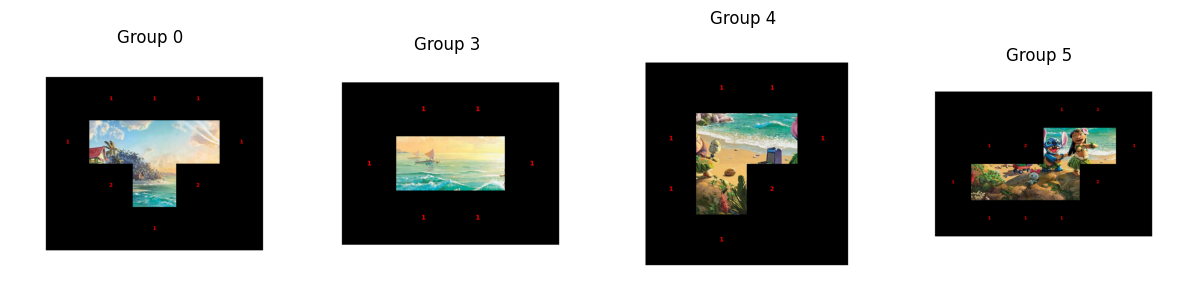

In [5]:
for comp in sorted_sides_comparisons:
    if comp.score <= global_values.IMAGE_TH:

        anchor_fragment_idx = comp.side1.fragment_idx
        pasted_fragment_idx = comp.side2.fragment_idx
        anchor_group_idx = fragment_idx_to_group_idx[anchor_fragment_idx]
        pasted_group_idx = fragment_idx_to_group_idx[pasted_fragment_idx]

        if anchor_group_idx != pasted_group_idx:

            shifted_anchor_group, shifted_pasted_group, pasted_group_additional_rotation = simulate_merge_positions(fragments, comp, groups[anchor_group_idx], groups[pasted_group_idx])

            if does_merge_fit_within_bounds(shifted_anchor_group):
                if check_groups_shapes_for_merging(shifted_anchor_group, shifted_pasted_group):
                    # print(f"{comp}")

                    if check_all_group_matchings_scores(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group):    
                        # score = calculate_all_group_matchings_scores(shifted_anchor_group, shifted_pasted_group)
                        # anchor_img = shifted_anchor_group.show_group(fragments,0)
                        # pasted_img = shifted_pasted_group.show_group(fragments,pasted_group_additional_rotation)
                        # plt.imshow(anchor_img)
                        # plt.show()
                        # plt.imshow(pasted_img)
                        # plt.show()
                        # print("-------------------------------------------")
                        groups[anchor_group_idx] = merge_groups(fragments, pasted_group_additional_rotation, shifted_anchor_group, shifted_pasted_group, fragment_idx_to_group_idx)
                        update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
                        print(comp)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 1)

# for g in groups:
#     print(g.fragment_positions)


Merged group 0 and 2 with total score: 0.0006262317765504122 using: Sides Comp: Score=0.015130280517041683 Fragment_idx1=0, Side_idx1=2; fragment_idx2=4, side_idx2=0
Merged group 0 and 2 with total score: 0.06504729914013296 using: Sides Comp: Score=0.0006262317765504122 Fragment_idx1=2, Side_idx1=2; fragment_idx2=6, side_idx2=0
Merged group 0 and 1 with total score: 0.10407185746589676 using: Sides Comp: Score=0.007346466649323702 Fragment_idx1=7, Side_idx1=0; fragment_idx2=3, side_idx2=2
Merged group 1 and 2 with total score: 0.9932156602541605 using: Sides Comp: Score=0.9999992847442627 Fragment_idx1=9, Side_idx1=2; fragment_idx2=14, side_idx2=2
No valid merge candidates found.


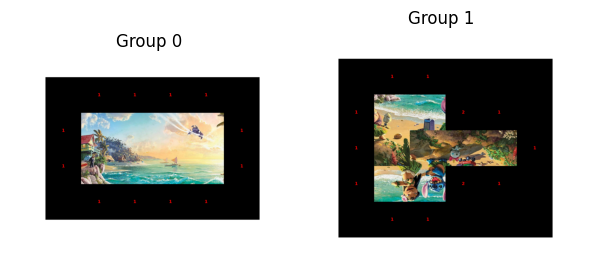

In [6]:
groups, fragments, fragment_idx_to_group_idx = solve_groups_safe(groups, fragments, fragment_idx_to_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)



In [7]:
gt_comparisons = read_valid_comparisons(solution_path)



comparisons = []

for g in groups:
    n = len(g.grid)
    m = len(g.grid[0])

    for i in range(n):
        for j in range(m):
            fr1_idx = g.grid[i][j]
            if fr1_idx is not None:
                if j + 1 < m:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 1)
                    fr2_idx = g.grid[i][j + 1]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation,3)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

                if i + 1 < n:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 2)
                    fr2_idx = g.grid[i + 1][j]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation, 0)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

correct = 0
nr_of_comp = int((2 * 4 + 3 * ((global_values.COL_NR - 2) * 2 + (global_values.ROW_NR - 2)* 2) + 4 * ((global_values.COL_NR -2) * (global_values.COL_NR-2)))/2)
for s_comp in comparisons:
    for gt_comp in gt_comparisons:
        if s_comp == gt_comp:
            correct+=1
        if s_comp[0] == gt_comp[1] and s_comp[1] == gt_comp[0] and s_comp[2] == gt_comp[3] and s_comp[3] == gt_comp[2]:
            correct+=1

accuracy = (correct/nr_of_comp) * 100
print(f"Accuracy of algorithm: {accuracy}%")

Accuracy of algorithm: 62.5%


In [8]:
# introducere problema imagini input output

# care e algolritmul (greedy)
# functia de potrivire
# siameza

# cum merge pe low level, simaza pe diferiti nr pixeli
# timp

# 9 iunie licenta
